# CNN Keras and TPUs

**Learning Objectives**

You will learn:

1. Read images and labels from TFRecords.

2. Training and validation datasets.

3. Predicting the model.

## Introduction 
This notebook is about training the model on TPU.

Each learning objective will correspond to a __#TODO__ in the notebook where you will complete the notebook cell's code before running. Refer to the [solution](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/image_understanding/solutions/Keras_Flowers_on_TPU.ipynb) for reference. 

## Imports

In [1]:
# The import statement combines two operations; it searches for the named module, then it binds the results of that search
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.3.2


## TPU detection

In [2]:
try: # detect TPUs
  tpu = None
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
  strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


## Configuration

In [3]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

if tpu:
  BATCH_SIZE = 16*strategy.num_replicas_in_sync  # A TPU has 8 cores so this will be 128
else:
  BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)

VALIDATION_SPLIT = 0.19
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 128, there will be 23 batches per training epoch and 5 batch(es) per validation run.


In [4]:
#@title display utilities

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  # In eager mode, iterate in the Datset directly.
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [5]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = # TODO: Your code goes here
    image = # TODO: Your code goes here  # convert image to floats in [0, 1] range
    image = # TODO: Your code goes here # explicit size will be needed for TPU
    one_hot_class = # TODO: Your code goes here
    one_hot_class = # TODO: Your code goes here
    return image, one_hot_class

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = # TODO: Your code goes here
  dataset = # TODO: Your code goes here
  dataset = # TODO: Your code goes here
  return dataset

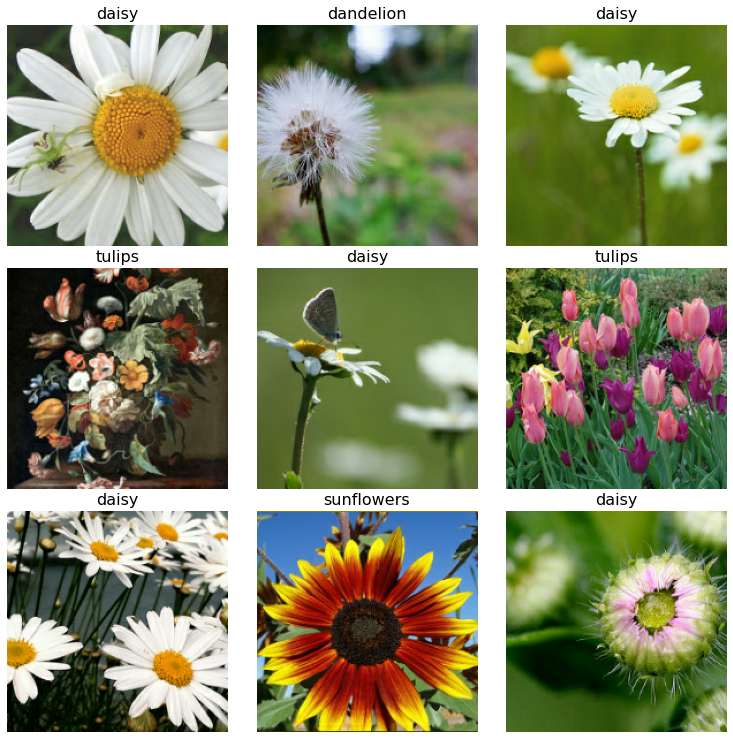

In [6]:
display_9_images_from_dataset(load_dataset(training_filenames))

## Training and validation datasets

In [7]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = # TODO: Your code goes here
validation_dataset = # TODO: Your code goes here

some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 160)

## Model

In [8]:
with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)

  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=[*IMAGE_SIZE, 3]),
      tf.keras.layers.Conv2D(kernel_size=3, filters=30, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=60, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=90, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=110, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=130, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=40, padding='same', activation='relu'),
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(5, activation='softmax')
  ])

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 30)      4350      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 60)        16260     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 90)        48690     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 90)        0

## Training

In [9]:
EPOCHS = 20

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/20
23/23 [==============================] - 14s 311ms/step - loss: 1.5760 - accuracy: 0.2273 - val_loss: 1.4421 - val_accuracy: 0.3304
Epoch 2/20
23/23 [==============================] - 3s 116ms/step - loss: 1.3383 - accuracy: 0.3982 - val_loss: 1.2303 - val_accuracy: 0.4667
Epoch 3/20
23/23 [==============================] - 3s 118ms/step - loss: 1.1833 - accuracy: 0.4571 - val_loss: 1.1404 - val_accuracy: 0.5188
Epoch 4/20
23/23 [==============================] - 3s 123ms/step - loss: 1.1135 - accuracy: 0.4989 - val_loss: 1.1039 - val_accuracy: 0.5217
Epoch 5/20
23/23 [==============================] - 3s 120ms/step - loss: 1.0782 - accuracy: 0.5141 - val_loss: 1.0728 - val_accuracy: 0.5754
Epoch 6/20
23/23 [==============================] - 3s 119ms/step - loss: 1.0434 - accuracy: 0.5545 - val_loss: 1.0607 - val_accuracy: 0.5652
Epoch 7/20
23/23 [==============================] - 3s 137ms/step - loss: 1.0284 - accuracy: 0.5491 - val_loss: 1.0132 - val_accuracy: 0.5899
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


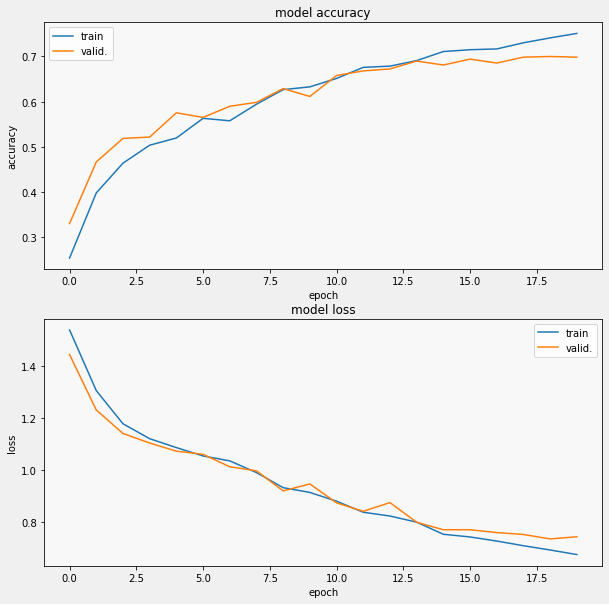

In [10]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## Predictions

In [11]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(160)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

# predict and evaluate the model
# TODO: Your code goes here
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

10/10 [==============================] - 3s 18ms/step - loss: 0.6836 - accuracy: 0.7312
['daisy', 'dandelion', 'tulips', 'daisy', 'daisy', 'dandelion', 'dandelion', 'roses', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'daisy', 'tulips', 'tulips', 'daisy', 'dandelion', 'roses', 'sunflowers', 'dandelion', 'dandelion', 'sunflowers', 'dandelion', 'dandelion', 'tulips', 'tulips', 'tulips', 'sunflowers', 'sunflowers', 'daisy', 'sunflowers', 'dandelion', 'tulips', 'dandelion', 'dandelion', 'roses', 'sunflowers', 'daisy', 'sunflowers', 'dandelion', 'daisy', 'tulips', 'dandelion', 'daisy', 'dandelion', 'sunflowers', 'daisy', 'dandelion', 'tulips', 'tulips', 'dandelion', 'sunflowers', 'sunflowers', 'sunflowers', 'tulips', 'daisy', 'dandelion', 'sunflowers', 'roses', 'sunflowers', 'dandelion', 'daisy', 'tulips', 'dandelion', 'tulips', 'daisy', 'tulips', 'daisy', 'roses', 'dandelion', 'tulips', 'dandelion', 'sunflowers', 'dandelion', 'tulips', 'roses', 'dandelion', 'sunflowers', 'daisy', 'dan

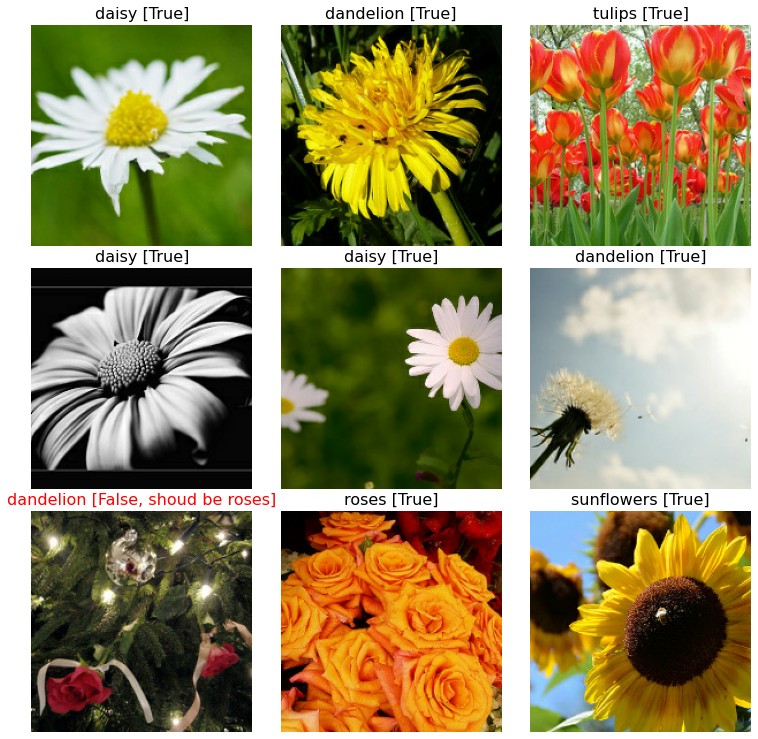

In [12]:
display_9_images_with_predictions(some_flowers, predictions, some_labels)

Copyright 2021 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.